In [1]:
import math
import numpy as np
import scipy.special as sp
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from numba import jit,int64,float64
import time
import scipy.optimize as sciopt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Plot template

# fig,ax = plt.subplots(1,1)
# ax.scatter(alphas_arr,stabilities_arr[:,0],c=CB_color_cycle[0],marker=">",label="fate 1")
# ax.scatter(alphas_arr,stabilities_arr[:,1],c=CB_color_cycle[1],marker="<",label="fate 2",alpha=1)
# ax.axhline(y=stability_thresh,c="k",ls="--",label="threshold")
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r"Noise coefficient $\alpha$",fontsize=18)
# ax.set_ylabel(r"Mean stability factor",fontsize=18)
# ax.legend(loc="best",fontsize=12)
# ax.set_title(f"Stability vs. noise",fontsize=20)
# fig.savefig("1b_stability_vs_noise.svg",format="svg")

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [19]:
#Parameters - self-activation a, cross-repression r, decay k, noise alpha:
a = np.array([0,0])
r = np.array([1,1])
k = np.array([1,1])
alpha = np.array([0.1,0.1])
#Hill coefficients:
n = np.array([[4,4],[4,4]])
theta = np.array([[0.5,0.5],[0.5,0.5]])

#The total time and dt::
T = 20
dt = 0.005
#Other time-related variables related to these two:
Nt = int(T/dt)
sqrt_dt = np.sqrt(dt)
TimeRange = np.arange(0,T,dt)
# #This is to calculate the dynamic threshold moving average:
# timeBase = 2*int(Nt/100)
# #Time to plot utility against:
# time_trunc = TimeRange[int((timeBase/2)-1):-int(timeBase/2)]

#Let's call num_traj the number of trajectories:
num_traj = 10000

#The initial conditions:
x0 = np.zeros((2,num_traj))
#Uniform around mean:
init_bias = 0
x0[0,:] = init_bias*np.ones(num_traj)

#The threshold above which we say x_i is high:
thresh = np.array([0.8,0.8])
#The stability threshold; a trajectory has to stay above this:
stability_thresh = 0.9

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [20]:
#Self-activation:
@jit(nopython=True)
def activation(x,a,n,theta):
    if (x>=0):
        return (a*x**n)/(x**n + theta**n)
    else:
        return 0

#Cross-inhibition
@jit(nopython=True)
def repression(x,r,n,theta):
    if (x>0):
        return (r*theta**n)/(x**n + theta**n)
    else:
        return 0

#Bias (for external signals):
@jit(nopython=True)
def ext_bias(x1,x2,t):
#     return (x1-x2,x2-x1)
    temp = 0
    return (temp,0)
    
#This solves the system fwd using simple Euler-Maruyama:
@jit(nopython=True)
def Solver(initial,a,r,k,n,theta,alpha):
    final = np.empty((2,num_traj,Nt))
    final[:,:,0] = initial
    #Solving the system forward in time:
    for i in range(num_traj):
        for t in range(1,Nt):
            #Equation for first species:
            temp = np.sqrt(np.maximum(final[0,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[0]*temp)
            final[0,i,t] = final[0,i,t-1] + dt*(activation(final[0,i,t-1],a[0],n[0,0],theta[0,0]) \
                                               + repression(final[1,i,t-1],r[0],n[1,0],theta[1,0]) \
                                               - k[0]*final[0,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[0]) \
                                                + sqrt_dt*noise
            #Equation for second:
            temp = np.sqrt(np.maximum(final[1,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[1]*temp)
            final[1,i,t] = final[1,i,t-1] + dt*(activation(final[1,i,t-1],a[1],n[1,1],theta[1,1]) \
                                               + repression(final[0,i,t-1],r[1],n[0,1],theta[0,1]) \
                                               - k[1]*final[1,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[1]) \
                                                + sqrt_dt*noise
    return final

#Classifier:
# @jit(nopython=True)
def fate_classifier(traj,thresh,stability_thresh):
    #Stability factor of trajectories:
    cross_flags = np.zeros((2,num_traj))
    cross_times = np.ones((2,num_traj))*Nt
    for axis_idx in range(2):
        #Axis crossings:
        for traj_idx in range(num_traj):
            if (np.size(np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0]) != 0):
                cross_flags[axis_idx,traj_idx] = 1
                cross_times[axis_idx,traj_idx] = np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0][0]
                    
    #Stability factor: after the threshold is crossed, how much time the traj spends above it:
    stability_factrs = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
#             if (cross_flags[axis_idx,traj_idx]==0):
#                 stability_factrs[axis_idx,traj_idx] = -1
            if (cross_flags[axis_idx,traj_idx]==1):
                stability_factrs[axis_idx,traj_idx] = np.sum(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):]>thresh[axis_idx])\
                /len(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):])
    
    #Stability threshold - trajectories that spend more than this above the concentration threshold are considered committed:
#     stability_thresh = 0.8
    #Classifying fates:
    fates = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
            if (cross_times[axis_idx,traj_idx]<=int(Nt/2) and stability_factrs[axis_idx,traj_idx]>=stability_thresh):
                fates[axis_idx,traj_idx]=1
                
    return stability_factrs,fates

In [21]:
#Generating some trajectories:
start_time = time.time()
traj_simple = np.empty((2,num_traj,Nt))
traj_simple = Solver(x0,a,r,k,n,theta,alpha)
end_time = time.time()
loop_time = end_time - start_time
print(f"Time taken: {loop_time} s.")

Time taken: 7.004162549972534 s.


In [22]:
#Now testing the fates and stability factors:
stability_factrs,fates = fate_classifier(traj_simple,thresh,stability_thresh)

In [23]:
np.mean(stability_factrs[0,stability_factrs[0]>0])

0.9891156862615854

In [26]:
#Varying initial bias and noise both, and calculating the sensitivity:
alphas_arr = np.array([(i+1)/25 for i in range(4)])
init_bias_arr = np.array([i/100 for i in range(11)])
#Finding stabilities:
stabilities_mean_arr = np.zeros((len(alphas_arr),len(init_bias_arr),2))
stabilities_std_arr = np.zeros((len(alphas_arr),len(init_bias_arr),2))
fate_frax = np.zeros((len(alphas_arr),len(init_bias_arr),4))

for alpha_idx in range(len(alphas_arr)):
    #Setting the noise:
    alpha[0] = alpha[1] = alphas_arr[alpha_idx]
    for bias_idx in range(len(init_bias_arr)):
        #The bias:
        init_bias = init_bias_arr[bias_idx]
        #Initial conditions:
        x0 = np.zeros((2,num_traj))
        x0[0,:] = init_bias*np.ones(num_traj)
        #Evolving:
        traj_alpha_bias = Solver(x0,a,r,k,n,theta,alpha)
        #Checking fates:
        stability_factrs,fates = fate_classifier(traj_alpha_bias,thresh,stability_thresh)
        #Finding fate fractions:
        fate_frax[alpha_idx,bias_idx,0] = np.sum((fates[0]==0) & (fates[1]==0))
        fate_frax[alpha_idx,bias_idx,1] = np.sum((fates[0]==1) & (fates[1]==0))
        fate_frax[alpha_idx,bias_idx,2] = np.sum((fates[0]==0) & (fates[1]==1))
        fate_frax[alpha_idx,bias_idx,3] = np.sum((fates[0]==1) & (fates[1]==1))
        #Finding mean stabilities:
        for axis_idx in range(2):
            stabilities_mean_arr[alpha_idx,bias_idx,axis_idx] = np.mean(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])
            stabilities_std_arr[alpha_idx,bias_idx,axis_idx] = np.std(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])
    
fate_frax = fate_frax/num_traj

In [30]:
stabilities_std_arr

array([[[0.0026389 , 0.00290296],
        [0.00271767, 0.00285365],
        [0.00260483, 0.00293951],
        [0.00274981, 0.00262402],
        [0.00276087, 0.00285068],
        [0.00263879, 0.00288757],
        [0.0026194 , 0.00255937],
        [0.00244923, 0.00213425],
        [0.00258905, 0.00312673],
        [0.00249273, 0.00247464],
        [0.00243452, 0.00258722]],

       [[0.01023275, 0.00954318],
        [0.00982873, 0.00978307],
        [0.00993656, 0.00987769],
        [0.00950139, 0.00965465],
        [0.01005922, 0.01022322],
        [0.00959155, 0.00982768],
        [0.00926466, 0.01052937],
        [0.00967066, 0.01026195],
        [0.00930978, 0.01081163],
        [0.00949127, 0.01028462],
        [0.00938567, 0.01017416]],

       [[0.02383665, 0.02297145],
        [0.02505008, 0.02387566],
        [0.0238818 , 0.02382997],
        [0.02316515, 0.02556359],
        [0.0226796 , 0.02462677],
        [0.02319408, 0.02417834],
        [0.02278253, 0.0234606 ],
        [0

In [29]:
fate_frax

array([[[0.000e+00, 5.034e-01, 4.966e-01, 0.000e+00],
        [0.000e+00, 5.460e-01, 4.540e-01, 0.000e+00],
        [0.000e+00, 6.610e-01, 3.390e-01, 0.000e+00],
        [0.000e+00, 7.530e-01, 2.470e-01, 0.000e+00],
        [0.000e+00, 8.296e-01, 1.704e-01, 0.000e+00],
        [0.000e+00, 8.984e-01, 1.016e-01, 0.000e+00],
        [0.000e+00, 9.405e-01, 5.950e-02, 0.000e+00],
        [0.000e+00, 9.677e-01, 3.230e-02, 0.000e+00],
        [0.000e+00, 9.831e-01, 1.690e-02, 0.000e+00],
        [0.000e+00, 9.934e-01, 6.600e-03, 0.000e+00],
        [0.000e+00, 9.973e-01, 2.700e-03, 0.000e+00]],

       [[0.000e+00, 5.027e-01, 4.973e-01, 0.000e+00],
        [1.000e-04, 5.280e-01, 4.719e-01, 0.000e+00],
        [2.000e-04, 5.825e-01, 4.173e-01, 0.000e+00],
        [0.000e+00, 6.340e-01, 3.660e-01, 0.000e+00],
        [1.000e-04, 6.822e-01, 3.177e-01, 0.000e+00],
        [1.000e-04, 7.271e-01, 2.728e-01, 0.000e+00],
        [1.000e-04, 7.716e-01, 2.283e-01, 0.000e+00],
        [2.000e-04, 8.218e

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


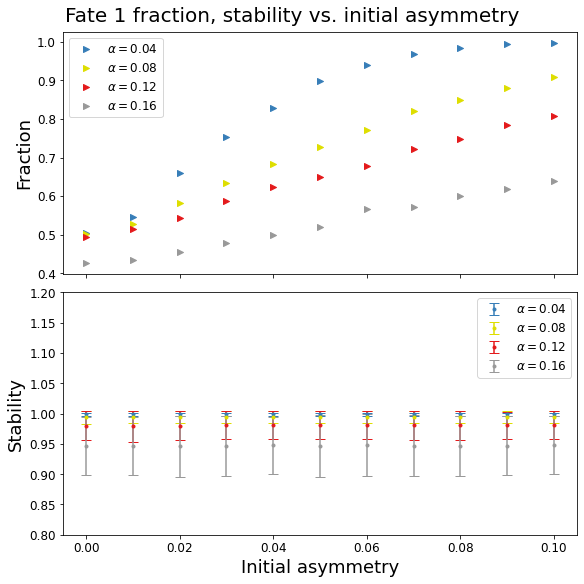

In [38]:
#Plot template

fig,ax = plt.subplots(2,1,sharex=True,figsize=[8,8],constrained_layout=True)
for alpha_idx in range(len(alphas_arr)):
    ax[0].scatter(init_bias_arr,fate_frax[alpha_idx,:,1],c=CB_color_cycle[-alpha_idx],marker=">",label=fr"$\alpha={alphas_arr[alpha_idx]}$")
# ax[0].scatter(init_bias_arr,fate_frax[1,:,1],c=CB_color_cycle[1],marker=">",label="fate 1 fraction")
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=10)
# ax[0].set_xlabel(r"Initial asymmetry",fontsize=18)
ax[0].set_ylabel(r"Fraction",fontsize=18)
ax[0].legend(loc="best",fontsize=12)
# ax[0].set_title(f"Final vs. inital asymmetry",fontsize=20)

for alpha_idx in range(len(alphas_arr)):
    ax[1].errorbar(init_bias_arr,stabilities_mean_arr[alpha_idx,:,0],yerr=stabilities_std_arr[alpha_idx,:,0],c=CB_color_cycle[-alpha_idx],capsize=5,fmt=".",label=fr"$\alpha={alphas_arr[alpha_idx]}$")
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=10)
ax[1].set_xlabel(r"Initial asymmetry",fontsize=18)
ax[1].set_ylabel(r"Stability",fontsize=18)
ax[1].set_ylim([0.8,1.2])
ax[1].legend(loc="best",fontsize=12)
# ax[1].set_title(f"Stability vs. inital asymmetry",fontsize=20)

fig.suptitle("Fate 1 fraction, stability vs. initial asymmetry",fontsize=20)

fig.savefig("2b_fraction,stability_vs_initial_noise.eps",format="eps",dpi=2000,bbox_inches="tight",pad_inches=0.15)

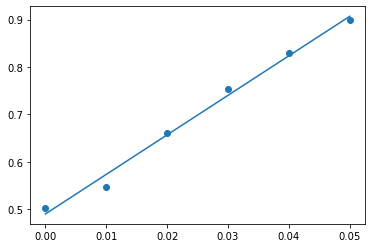

In [46]:
#Finding the sensitivity:
plt.scatter(init_bias_arr[:6],fate_frax[0,:6,1])
#Fitting:
x_fit = init_bias_arr[:6]
y_fit = fate_frax[0,:6,1]

#Linear function to fit against:
# @jit(nopython=True)
def fit_linear(x,a,b):
    return a*x+b

popt,pcov = sciopt.curve_fit(fit_linear,x_fit,y_fit,p0=([2,0.1]))

plt.plot(x_fit,fit_linear(x_fit,*popt))

In [45]:
popt,pcov

(array([8.33657142, 0.49015238]),
 array([[ 1.74530394e-01, -4.36325983e-03],
        [-4.36325983e-03,  1.59986193e-04]]))